In [ ]:
#remove " > /dev/null 2>&1" to see what is going on under the hood
!pip install gym pyvirtualdisplay > /dev/null 2>&1
!apt-get install -y xvfb python-opengl ffmpeg > /dev/null 2>&1

Pacman Dependancies

In [ ]:
!apt-get update > /dev/null 2>&1
!apt-get install cmake > /dev/null 2>&1
!pip install --upgrade setuptools 2>&1
!pip install ez_setup > /dev/null 2>&1
!pip install gym[atari] > /dev/null 2>&1

In [ ]:
%pip install -U gym>=0.21.0
%pip install -U gym[atari,accept-rom-license]

# Imports and Helper functions


In [ ]:
!wget https://raw.githubusercontent.com/openai/baselines/master/baselines/common/wrappers.py
!wget https://raw.githubusercontent.com/openai/baselines/master/baselines/common/atari_wrappers.py

In [ ]:
import gym
import numpy as np
import random
import math
import matplotlib.pyplot as plt
from IPython import display as ipythondisplay

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import os.path
plt.style.use('ggplot')

from atari_wrappers import wrap_deepmind,  make_atari 

from pyvirtualdisplay import Display
display = Display(visible=0, size=(400, 300))
display.start()

In [ ]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [ ]:
env_id = "PongNoFrameskip-v4" 
env = make_atari(env_id)
env = wrap_deepmind(env)

In [ ]:
# directory = './PongVideos/'
# env = gym.wrappers.Monitor(env, directory, video_callable = lambda episode_id: episode_id%20)

In [ ]:
# import gym.spaces

# DEFAULT_ENV_NAME = "PongNoFrameskip-v4" 
# env = gym.make(DEFAULT_ENV_NAME)
# print(env.action_space.n)

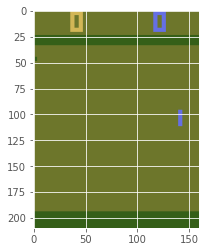

In [ ]:
prev_screen = env.render(mode='rgb_array')
plt.imshow(prev_screen)
plt.show()

In [ ]:
# Set the seed for env, pytorch and random module
seed = 27
torch.manual_seed(seed)
random.seed(seed)

In [ ]:
state_space = env.observation_space.shape[0]
action_space = env.action_space.n

In [ ]:
def calculate_epsilon(steps_done):
    epsilon = egreedy_final + (egreedy - egreedy_final) * \
                math.exp(-1. * steps_done / egreedy_decay)
    return epsilon

In [ ]:
# define hyperparameters
num_episode = 500
gamma = 0.99
learning_rate = 0.0001

egreedy = 0.9
egreedy_final = 0.01
egreedy_decay = 10000

hidden_layer = 512
print_every = 10

egreedy_total = []

replay_memory_size = 100000
batch_size = 32
update_target_freq = 7000

score_to_solve = 19

clip_error = False
double_dqn = True
normalize_image = True

In [ ]:
class ExperienceReplay(object):
    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def push(self, state, action, new_state, reward, done):
        transition = (state, action, new_state, reward, done)
        
        if self.position >= len(self.memory):
            self.memory.append(transition)
        else:
            self.memory[self.position] = transition

        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return zip(*random.sample(self.memory, batch_size))

    def __len__(self):
        return len(self.memory)

In [ ]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super(NeuralNetwork, self).__init__()
        self.conv1 = nn.Conv2d(in_channels= 1, out_channels=32, kernel_size=8, stride=4)
        self.conv2 = nn.Conv2d(in_channels= 32, out_channels=64, kernel_size=4, stride=2)
        self.conv3 = nn.Conv2d(in_channels= 64, out_channels=64, kernel_size=3, stride=1)
        
        self.advantage1 = nn.Linear(7*7*64, hidden_layer)
        self.advantage2 = nn.Linear(hidden_layer, action_space)

        self.value1 = nn.Linear(7*7*64, hidden_layer)
        self.value2 = nn.Linear(hidden_layer, 1)

    def forward(self, x):
        if normalize_image:
            x = x/255.

        out = F.relu(self.conv1(x))
        out = F.relu(self.conv2(out))
        out = F.relu(self.conv3(out))

        out = out.view(out.size(0), -1) # Flatten the output layer from CN Layers

        out_advantage = F.relu(self.advantage1(out))
        out_advantage = self.advantage2(out_advantage)

        out_value = F.relu(self.value1(out))
        out_value = self.value2(out_value)

        final_out = out_value + out_advantage - out_advantage.mean()
        return final_out

In [ ]:
class QNet_Agent(object):
    def __init__(self):
        self.nn = NeuralNetwork().to(device)
        self.target_nn = NeuralNetwork().to(device)
        self.loss_func = nn.MSELoss()
        self.optimizer = optim.Adam(params = self.nn.parameters(), lr = learning_rate)

        self.num_of_frames = 0

        if resume_previous_training and os.path.exists(file2save):
            self.nn.load_state_dict(load_model()) # Load previous saved model

    def select_Action(self, state, epsilon):

        random_greedy = torch.rand(1)[0]

        if random_greedy > epsilon:
            with torch.no_grad():
                state = preprocess_frame(state)
                action_from_nn = self.nn(state)
                action = torch.max(action_from_nn, 1)[1]
                action = action.item()
        else:
            action = env.action_space.sample()

        return action

    def optimize(self):

        if len(memory) < batch_size:
            return 

        state, action, new_state, reward, done = memory.sample(batch_size)
        
        state = [preprocess_frame(frame) for frame in state]
        state = torch.cat(state)

        new_state = [preprocess_frame(frame) for frame in new_state]
        new_state = torch.cat(new_state)

        #state = torch.Tensor(state).to(device)
        #new_state = torch.Tensor(new_state).to(device)
        reward = torch.Tensor(reward).to(device)
        action = torch.LongTensor(action).to(device)
        done = torch.Tensor(done).to(device)

        if double_dqn:
            new_state_indexes = self.nn(new_state).detach()
            max_new_state_indexes = torch.max(new_state_indexes, 1)[1]

            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = new_state_values.gather(1, max_new_state_indexes.unsqueeze(1)).squeeze(1)

        else:
            new_state_values = self.target_nn(new_state).detach()
            max_new_state_values = torch.max(new_state_values, 1)[0]

        target_value = reward + ( 1 - done ) * gamma * max_new_state_values
  
        predicted_value = self.nn(state).gather(1, action.unsqueeze(1)).squeeze(1)
        
        loss = self.loss_func(predicted_value, target_value)
    
        self.optimizer.zero_grad()
        loss.backward()

        if clip_error:
            for param in self.nn.parameters():
                param.grad.data.clamp_(-1, 1)
        self.optimizer.step()

        if self.num_of_frames % update_target_freq == 0:
            self.target_nn.load_state_dict(self.nn.state_dict())

        if self.num_of_frames % save_model_frequency == 0:
            save_model(self.nn)

        self.num_of_frames += 1
 

In [ ]:
def plot_result():
    plt.figure(figsize=(12,5))
    plt.title("Rewards")
    plt.plot(total_rewards, alpha=0.6, color='red')
    plt.savefig('pong_result.png')
    plt.close()

In [ ]:
agent = QNet_Agent()
memory = ExperienceReplay(replay_memory_size)

In [ ]:
file2save = 'pong_save.pth'
save_model_frequency = 10000
resume_previous_training = False

In [ ]:
def load_model():
    return torch.load(file2save)

def save_model(model):
    return torch.save(model.state_dict(), file2save)

def preprocess_frame(frame):
    frame = frame.transpose((2, 0, 1))
    frame = torch.from_numpy(frame)
    
    frame = frame.to(device, dtype = torch.float32)
    frame = frame.unsqueeze(1)
    return frame

In [ ]:
total_rewards = []
solved = False
total_frames = 0
start_time = time.time()


for i_episode in range(num_episode):
    state = env.reset()
    score = 0
    #for step in range(100):
    while True:

        total_frames += 1

        epsilon = calculate_epsilon(total_frames)
        action = agent.select_Action(state, epsilon)
        new_state, reward, done, info = env.step(action)

        score += reward
        memory.push(state, action, new_state, reward, done)

        agent.optimize()
        
        state = new_state

        # screen = env.render(mode='rgb_array')
        # plt.imshow(screen)
        # ipythondisplay.clear_output(wait=True)
        # ipythondisplay.display(plt.gcf())
        if done:
            total_rewards.append(score)
            
            mean_reward_100 = sum(total_rewards[-100:])/100
            
            if (mean_reward_100 > score_to_solve and solved == False):
                print("SOLVED! After %i episodes " % i_episode)
                solved_after = i_episode
                solved = True
            
            if (i_episode % print_every == 0 and i_episode > 0):
                plot_result()
                print("\n*** Episode %i *** \
                      \nAv.reward: [last %i]: %.2f, [last 100]: %.2f, [all]: %.2f \
                      \nepsilon: %.2f, total_frames: %i" 
                  % (i_episode,
                    print_every,
                    sum(total_rewards[-print_every:])/print_every,
                    mean_reward_100,
                    sum(total_rewards)/len(total_rewards),
                    epsilon,
                    total_frames
                          ))
                elapsed_time = time.time() - start_time
                print("Elapsed time: ", time.strftime("%H:%M:%S", time.gmtime(elapsed_time)))
            break


*** Episode 10 ***                       
Av.reward: [last 10]: -20.60, [last 100]: -2.25, [all]: -20.45                       
epsilon: 0.34, total_rewards: 9814
Elapsed time:  00:01:41

*** Episode 20 ***                       
Av.reward: [last 10]: -20.50, [last 100]: -4.30, [all]: -20.48                       
epsilon: 0.15, total_rewards: 18576
Elapsed time:  00:03:14

*** Episode 30 ***                       
Av.reward: [last 10]: -19.90, [last 100]: -6.29, [all]: -20.29                       
epsilon: 0.06, total_rewards: 28754
Elapsed time:  00:05:06

*** Episode 40 ***                       
Av.reward: [last 10]: -20.90, [last 100]: -8.38, [all]: -20.44                       
epsilon: 0.03, total_rewards: 37519
Elapsed time:  00:06:41

*** Episode 50 ***                       
Av.reward: [last 10]: -20.80, [last 100]: -10.46, [all]: -20.51                       
epsilon: 0.02, total_rewards: 46394
Elapsed time:  00:08:18

*** Episode 60 ***                       
Av.reward: [

In [90]:
print("Average reward: %.2f" % (sum(total_rewards)/num_episode))
print("Average reward (last 100 episodes): %.2f" % (sum(total_rewards[-100:])/100))


Average reward: -1.75
Average reward (last 100 episodes): 18.58


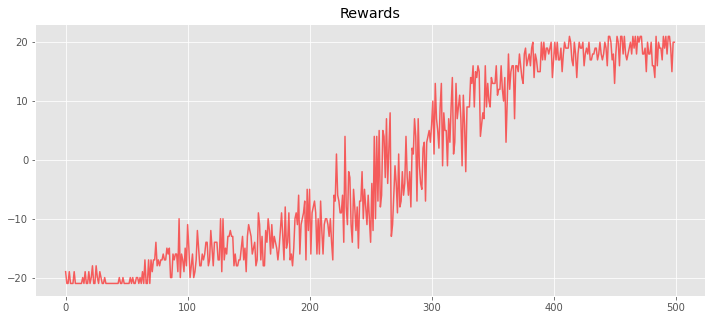

In [92]:
# Plot graphs for rewards and steps   
plt.figure(figsize=(12,5))
plt.title("Rewards")
plt.plot(total_rewards, alpha=0.6, color='red')
plt.show()

In [ ]:
env.close()